# NLP From Scratch: Classifying Names with a Character-Level RNN

Based on the tutorial: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [1]:
NAME = 'char_rnn_classification'
SAVE_PATH = f'data/test/train/{NAME}-checkpoint.pth'
REPORT_PATH = f'data/test/train/{NAME}-report.pdf'
DATA_PATH = 'data/char_rnn'
RANDOM_SEED = 0

In [2]:
import sys
if "../" not in sys.path:
  sys.path.append("../")

In [3]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [4]:
import random
import torch
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

### Preparing the Data

In [5]:
from synth_mind.supervised.data import SplitData
from datasets.names_data import NamesData
from lib import data_utils
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def transform(item: tuple[str, int]):
    input, target = item
    input = data_utils.unicode_to_ascii(s=input, allowed_letters=all_letters)
    return input, target

data = NamesData(root_path=DATA_PATH, split_data=SplitData(val_percent=0.2, test_percent=None), random_seed=RANDOM_SEED)
datasets = data.datasets.transform(transform)
all_categories = data.all_labels
n_categories = len(all_categories)

In [6]:
print(sorted([i for i in datasets.filter(lambda x: x[1] == all_categories.index('Italian')).transform(lambda x: x[0]).train])[:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### Turning Names into Tensors

In [7]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_tensor('J'))

print(line_to_tensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


### Creating the Network

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input: torch.Tensor, hidden: torch.Tensor | None):
        hidden = hidden if hidden is not None else self.init_hidden()
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [9]:
input = letter_to_tensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [10]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8044, -2.7603, -2.9622, -3.0277, -2.8133, -2.9648, -2.8769, -2.9672,
         -3.0306, -2.7559, -2.9969, -2.7296, -2.9386, -2.8684, -2.8874, -2.9012,
         -2.8629, -2.9531]], grad_fn=<LogSoftmaxBackward0>)


### Preparing for Training

In [11]:
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(category_from_output(output))

('Korean', 11)


In [12]:
def transform_to_tensor(item: tuple[str, int]):
    input, target = item
    input_tensor = line_to_tensor(input)
    target_tensor = torch.tensor([target], dtype=torch.long)
    return input_tensor, target_tensor

tensor_datasets = datasets.transform(transform_to_tensor).sized()

for line_tensor, category_tensor in iter(tensor_datasets.limit(10).train):
    category = all_categories[int(category_tensor[0].item())]
    line = ''.join([all_letters[int(i)] for i in line_tensor[:, 0].argmax(dim=1)])
    print('category =', category, '/ line =', line)

category = French / line = Deforest
category = Italian / line = Alberghini
category = Russian / line = Paraskun
category = English / line = Woodley
category = Scottish / line = Ritchie
category = Russian / line = Zhivago
category = English / line = Ocallaghan
category = Italian / line = Ungaretti
category = Russian / line = Viron
category = Japanese / line = Ui


In [13]:
import random
from torch.utils.data import DataLoader, Dataset
from synth_mind.supervised.data import IterDataset

def get_dataloader(dataset: Dataset[tuple[torch.Tensor, torch.Tensor]], batch_size: int, amount: int) -> DataLoader:
    def generator():
        items = [i for i in dataset]
        items_per_cat_idx = {i: [] for i in range(n_categories)}

        for i in items:
            items_per_cat_idx[int(i[1])] += [i]

        for _ in range(amount):
            cat_idx = random.randint(0, n_categories - 1)
            cat_items = items_per_cat_idx[cat_idx]
            idx  = random.randint(0, len(cat_items) - 1)
            yield cat_items[idx]

    return DataLoader(IterDataset(generator), batch_size=batch_size)

def get_train_dataloader(amount: int):
    return get_dataloader(tensor_datasets.train, batch_size=1, amount=amount)

def get_val_dataloader(amount: int):
    assert tensor_datasets.validation is not None
    return get_dataloader(tensor_datasets.validation, batch_size=1, amount=amount)

### Training the Network

In [14]:
criterion = nn.NLLLoss()

In [15]:
import typing

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

class MyOptimizer(torch.optim.Optimizer):
    def __init__(self, params: typing.Iterator[torch.nn.Parameter], lr: float):
        defaults = dict(lr=lr)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure: typing.Optional[typing.Callable[[], float]] = None): # type: ignore
        loss = None

        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for param_untyped in group['params']:
                p: torch.nn.Parameter = param_untyped
                if p.grad is not None:
                    learning_rate = group['lr']
                    p.data.add_(p.grad.data, alpha=-learning_rate)

        return loss

### Create the Manager

In [16]:
import typing
from synth_mind import supervised
from synth_mind.supervised.handlers import Evaluator, GeneralBatchAccuracyCalculator, BatchExecutor
from lib.metrics import (
    MetricsListPlotter, MainMetrics, TruePredictedClassMetrics, MetricsFileDirectPlotter)

EPOCHS = 20
N_ITERS = 100000
BATCHES = N_ITERS // EPOCHS
N_CONFUSION = 1000
N_PREDICTIONS = 3

train_dataloader = get_train_dataloader(BATCHES)
validation_dataloader = get_val_dataloader(N_CONFUSION)

class MyBatchExecutor(BatchExecutor[torch.Tensor, tuple[torch.Tensor, torch.Tensor]]):
    def run(self, params) -> tuple[torch.Tensor, torch.Tensor]:
        model = params.model
        input_batch = params.input
        assert len(input_batch) == 1
        input_tensor = input_batch.squeeze(0)

        output: torch.Tensor | None = None
        hidden: torch.Tensor | None = None

        for i in range(input_tensor.size()[0]):
            output, hidden = model(input_tensor[i], hidden)

        assert output is not None
        assert hidden is not None

        return output, hidden

    def main_output(self, output) -> torch.Tensor:
        main_output, _ = output
        return main_output

class MyEvaluator(Evaluator[typing.Any, None]):
    def __init__(self, n_predictions=3):
        self.n_predictions = n_predictions

    def run(self, params):
        with torch.no_grad():
            input_line = params.input
            model = params.model

            n_predictions = self.n_predictions

            print('\n> %s' % input_line)

            output = self.evaluate(model=model, line_tensor=line_to_tensor(input_line))

            # Get top N categories
            topv, topi = output.topk(n_predictions, 1, True)
            predictions = []

            for i in range(n_predictions):
                value = topv[0][i].item()
                category_index = int(topi[0][i].item())
                print('(%.2f) %s' % (value, all_categories[category_index]))
                predictions.append([value, all_categories[category_index]])

    def evaluate(self, model: torch.nn.Module, line_tensor: torch.Tensor) -> torch.Tensor:
        output: torch.Tensor | None = None
        hidden: torch.Tensor | None = None

        for i in range(line_tensor.size()[0]):
            output, hidden = model(line_tensor[i], hidden)

        assert output is not None

        return output

class MyLoss(torch.nn.Module):
    def forward(self, output: torch.Tensor, target: torch.Tensor):
        return criterion(output, target.squeeze(-1))

manager = supervised.Manager(
    data_params=ManagerDataParams(
        train_dataloader=train_dataloader,
        validation_dataloader=validation_dataloader,
        test_dataloader=None,
    ),
    model_params=supervised.ManagerModelParams(
        model=rnn,
        criterion=MyLoss(),
        executor=MyBatchExecutor(),
        use_best=False,
    ),
    optimizer_params=supervised.ManagerOptimizerParams(
        optimizer=MyOptimizer(params=rnn.parameters(), lr=learning_rate),
        scheduler=None,
        train_early_stopper=None,
        test_early_stopper=None,
    ),
    metrics_params=supervised.ManagerMetricsParams(
        evaluator=MyEvaluator(),
        accuracy_calculator=GeneralBatchAccuracyCalculator(),
        metrics_calculator=MetricsFileDirectPlotter(
            plotter=MetricsListPlotter(items=[
                MainMetrics(name=NAME),
                TruePredictedClassMetrics(
                    name=f"{NAME}_matrix_train",
                    dataset=train_dataloader.dataset,
                    categories=all_categories,
                    executor=MyBatchExecutor()),
                TruePredictedClassMetrics(
                    name=f"{NAME}_matrix_val",
                    dataset=validation_dataloader.dataset,
                    categories=all_categories,
                    executor=MyBatchExecutor()
                ),
            ]),
            file_path=REPORT_PATH,
            figsize=(8, 8),
        ),
        batch_interval=False,
        save_every=1,
        print_every=1,
        metric_every=1,
    ),
    config=supervised.ManagerConfig(
        save_path=SAVE_PATH,
        random_seed=RANDOM_SEED,
        train_hook=None,
    ),
)

### Training, Plotting and Evaluating the Results

Starting training for 20 epochs...
[end of epoch  1 (  5.0%)] [time:   0m 24.15s (-   7m 38.92s)] [val_accuracy:  28.7%, train_accuracy:  19.8%] [val_loss: 2.3340, train_loss: 2.6603]
[end of epoch  2 ( 10.0%)] [time:   0m 42.57s (-   6m 23.11s)] [val_accuracy:  36.2%, train_accuracy:  34.7%] [val_loss: 1.9403, train_loss: 2.0658]
[end of epoch  3 ( 15.0%)] [time:    1m 0.27s (-   5m 41.52s)] [val_accuracy:  39.6%, train_accuracy:  42.0%] [val_loss: 1.7768, train_loss: 1.8042]
[end of epoch  4 ( 20.0%)] [time:   1m 19.93s (-   5m 19.71s)] [val_accuracy:  42.8%, train_accuracy:  46.3%] [val_loss: 1.6902, train_loss: 1.6413]
[end of epoch  5 ( 25.0%)] [time:    2m 0.42s (-    6m 1.26s)] [val_accuracy:  43.0%, train_accuracy:  50.3%] [val_loss: 1.6601, train_loss: 1.5471]
[end of epoch  6 ( 30.0%)] [time:   2m 16.55s (-   5m 18.62s)] [val_accuracy:  42.5%, train_accuracy:  53.3%] [val_loss: 1.5961, train_loss: 1.4443]
[end of epoch  7 ( 35.0%)] [time:   2m 31.53s (-   4m 41.40s)] [val_acc

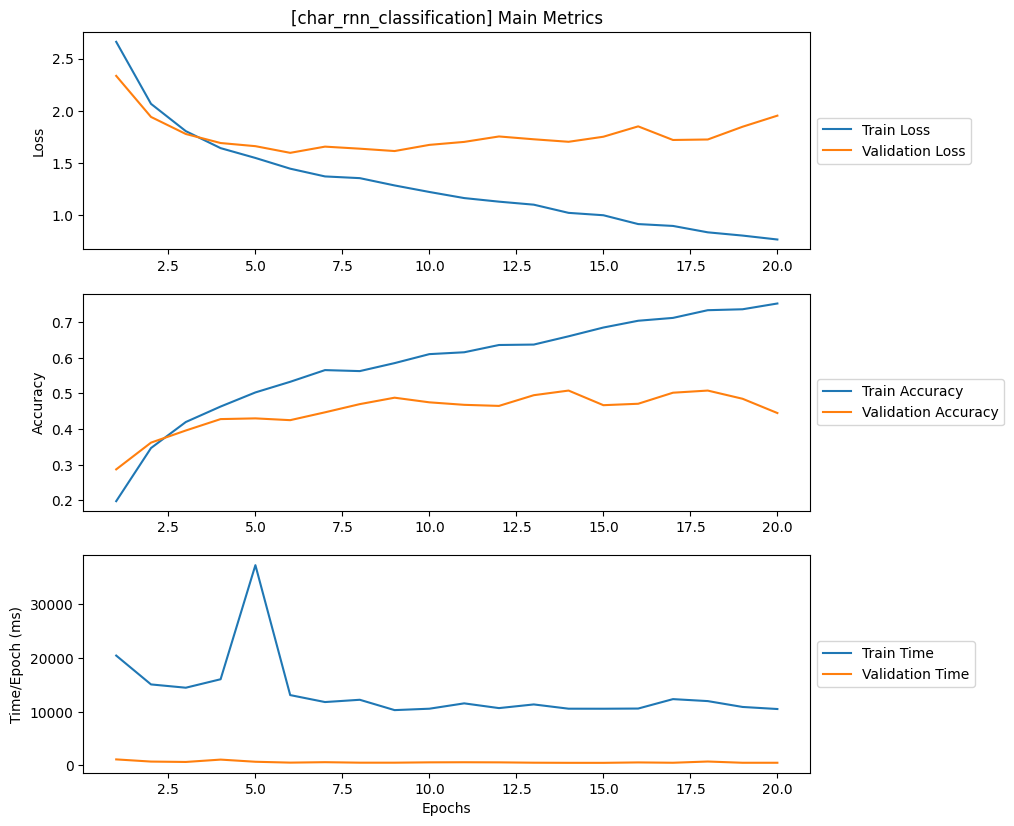

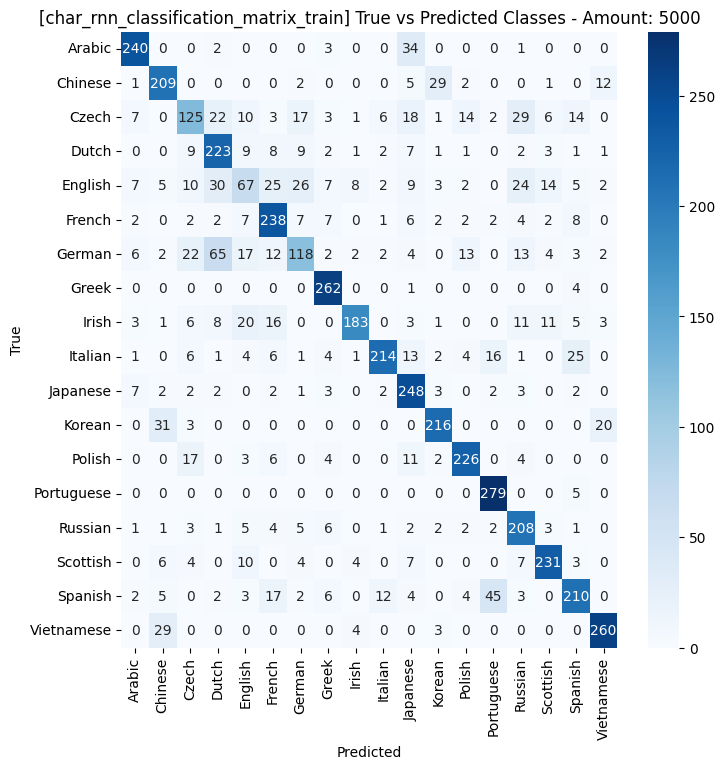

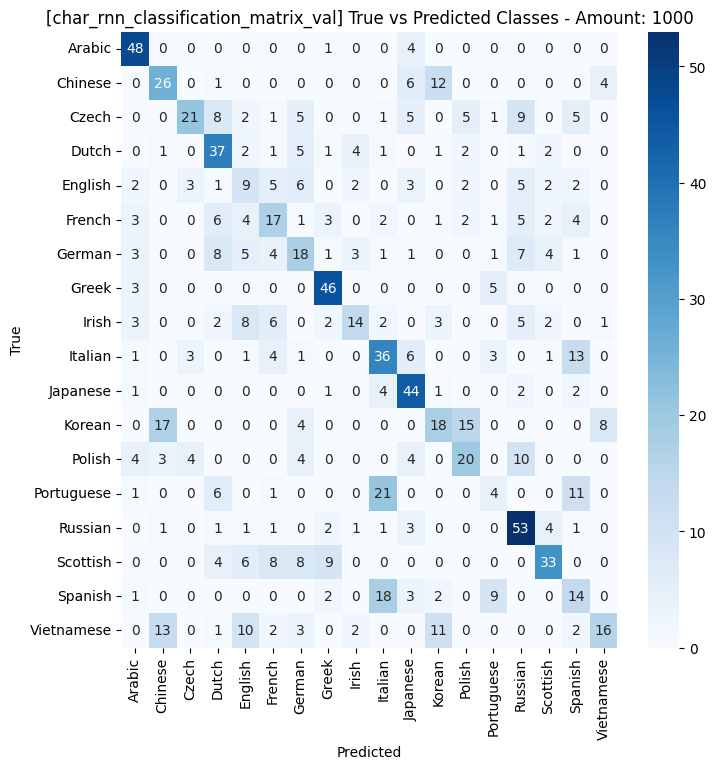

In [17]:
manager.train(epochs=EPOCHS)

### Running on User Input

In [18]:
manager.evaluate('Dovesky')
manager.evaluate('Jackson')
manager.evaluate('Satoshi')


> Dovesky
(-0.08) Russian
(-3.15) Czech
(-4.14) English

> Jackson
(-0.43) Scottish
(-1.46) Russian
(-3.01) English

> Satoshi
(-0.18) Japanese
(-2.72) Arabic
(-3.32) Italian
